In [184]:
import pandas as pd
from sqlalchemy import create_engine
from scipy import stats

sql_engine = create_engine('sqlite:///../data/processed/database.sqlite', echo=False)
connection = sql_engine.raw_connection()

### Examine proportions of each label

Here 'accept', 'ignore' and 'reject' correspond to marking OK, X or PASS in the prodigy interface. The rest of labels correspond to categories chosen in the interface.

In [185]:
query_n_labels = ('select l.label_name, count(*) as n from judgements j '
                  'inner join judgements_to_labels jtl on jtl.judgement_id = j.judgement_id '
                  'inner join labels l on l.label_id = jtl.label_id '
                  'group by l.label_name '
                  'order by count(*) '
                  'desc')

df = pd.read_sql_query(query_n_labels, connection)
df

label_name    n
0            accept  396
1            TYPE_A  311
2         DISMISSED  209
3            TYPE_B  107
4   RETURN_TO_TRIAL  104
5          APPROVED   85
6  REGULAR_LANGUAGE   58
7  REVERSE_LANGUAGE   49
8            ignore   22

In [186]:
n_total = 0
for answer in ['accept', 'ignore', 'reject']:
    v = df[df.label_name == answer].n.values
    n_total += v[0] if v else 0

/home/alvaro/.virtualenvs/asylum_appeal_classifier/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  after removing the cwd from sys.path.


### Check lengths of the texts under each category

In [187]:
df_lens = pd.read_sql_query(
    'select l.label_name, length(text) as len from judgements j '
    'inner join judgements_to_labels jtl on jtl.judgement_id = j.judgement_id '
    'inner join labels l on l.label_id = jtl.label_id ', connection)

#### Plot mean lengths 

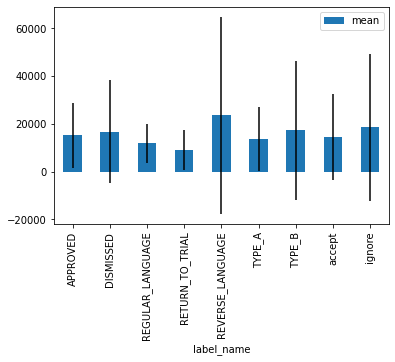

In [188]:
df_std = df_lens.groupby('label_name').agg('std').rename({'len': 'std'}, axis=1)
df_mean = df_lens.groupby('label_name').agg('mean').rename({'len': 'mean'}, axis=1)
df_mean['std'] = df_std['std']
df_mean.plot(kind='bar', y='mean', yerr='std')

## Statistical tests

##### Do lengths from RETURN_TO_TRIAL, APPROVED, DISMISSED seem to be equal?

In [189]:
from scipy.stats import kruskal, mannwhitneyu

lens_dismissed = df_lens[df_lens.label_name == 'DISMISSED'].len.values
lens_return = df_lens[df_lens.label_name == 'RETURN_TO_TRIAL'].len.values
lens_approved = df_lens[df_lens.label_name == 'APPROVED'].len.values

stats_, p_ = kruskal(lens_dismissed, lens_return, lens_approved)
if p > 0.05:
    print('- Same distribution (fail to reject H0)')
else:
    print('- Different distribution (reject H0)')

- Different distribution (reject H0)


##### Do lengths from TYPE_A, TYPE_B seem to be equal?

In [190]:
lens_type_a = df_lens[df_lens.label_name == 'TYPE_A'].len.values
lens_type_b = df_lens[df_lens.label_name == 'TYPE_B'].len.values

stat, p = mannwhitneyu(lens_type_a, lens_type_b)
print('TYPE A/TYPE B:\n- Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('- Same distribution (fail to reject H0)')
else:
    print('- Different distribution (reject H0)')

TYPE A/TYPE B:
- Statistics=15411.500, p=0.128
- Same distribution (fail to reject H0)


##### Do lengths from REGULAR_LANGUAGE, REVERSE_LANGUAGE seem to be equal?

In [191]:
lens_reg_lang = df_lens[df_lens.label_name == 'REGULAR_LANGUAGE'].len.values
lens_reverse_lang = df_lens[df_lens.label_name == 'REVERSE_LANGUAGE'].len.values

stat, p = mannwhitneyu(lens_reg_lang, lens_reverse_lang)
print('REGULAR/REVERSE LANG:\n- Statistics=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('- Same distribution (fail to reject H0)')
else:
    print('- Different distribution (reject H0)')

REGULAR/REVERSE LANG:
- Statistics=1086.000, p=0.018
- Different distribution (reject H0)


## Examine proportions in each dataset

In [192]:
query_n_labels = ('select l.label_name, d.name as dataset_name, count(*) as n from judgements j '
                  'inner join judgements_to_labels jtl on jtl.judgement_id = j.judgement_id '
                  'inner join labels l on l.label_id = jtl.label_id '
                  'inner join judgements_to_datasets jtd on jtd.judgement_id = j.judgement_id '
                  'inner join datasets d on d.dataset_id = jtd.dataset_id '
                  'group by l.label_name, d.name '
                  'order by count(*) '
                  'desc')

df = pd.read_sql_query(query_n_labels, connection).sort_values(by=['label_name', 'dataset_name'])
df

label_name dataset_name    n
20          APPROVED         test   12
7           APPROVED        train   57
16          APPROVED   validation   16
12         DISMISSED         test   30
2          DISMISSED        train  150
13         DISMISSED   validation   29
21  REGULAR_LANGUAGE         test   10
10  REGULAR_LANGUAGE        train   42
24  REGULAR_LANGUAGE   validation    6
14   RETURN_TO_TRIAL         test   18
4    RETURN_TO_TRIAL        train   70
17   RETURN_TO_TRIAL   validation   16
23  REVERSE_LANGUAGE         test    8
11  REVERSE_LANGUAGE        train   32
22  REVERSE_LANGUAGE   validation    9
9             TYPE_A         test   44
1             TYPE_A        train  218
8             TYPE_A   validation   49
15            TYPE_B         test   18
3             TYPE_B        train   74
19            TYPE_B   validation   15
5             accept         test   61
0             accept        train  276
6             accept   validation   59
26            ignore         test    1
18            ignore        train   16
25            ignore   validation    5